
*Pontifica Universidad Javeriana*

 *DPTO Ing Sistemas*

 **Materia** Procesamiento de Datos a Gran Escala

 **Autores:** Daniel Torres, Daniel Sandoval e Isaac Janica

**Fecha:**




In [0]:
# Se importan de las bibliotecas necesarias
import pyspark
from pyspark import SparkContext  #Importa la clase Spark context
from pyspark.sql import SQLContext, Row, Column #SqlContext permite poder hacer queries y operaciones con DataFrames de spark
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd

from pyspark.ml.feature import DenseVector, StandardScaler

import matplotlib.pyplot as plt

# Creación del objeto SparkContext para poder trabjar con PySpark y sus dataframes
sc = SparkContext.getOrCreate()
sql_sc = SQLContext(sc)
sc


# File location and type
file_location = "/FileStore/tables/Motor_Vehicle_Collisions___Vehicles_20240304-2.csv"
file_type = "csv"
#colli_pd = pd.read_csv(file_location)
#CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
# Read CSV file into a Spark DataFrame
df = spark.read.csv(file_location, header=first_row_is_header, inferSchema=infer_schema, sep=delimiter)
dfp = df.toPandas()
df.limit(4).toPandas()
#print(colli_pd)

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2
0,10385780,100201,09/07/2012,9:03,1,NY,PASSENGER VEHICLE,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Unspecified,None
1,19140702,4213082,09/23/2019,8:15,0553ab4d-9500-4cba-8d98-f4d7f89d5856,NY,Station Wagon/Sport Utility Vehicle,TOYT -CAR/SUV,None,2002,North,1,M,Licensed,NY,Going Straight Ahead,Left Front Bumper,Left Front Quarter Panel,None,None,None,N,None,Driver Inattention/Distraction,Unspecified
2,14887647,3307608,10/02/2015,17:18,2,NY,TAXI,None,None,None,None,None,None,None,None,Going Straight Ahead,None,None,None,None,None,None,None,Driver Inattention/Distraction,None
3,14889754,3308693,10/04/2015,20:34,1,NY,PASSENGER VEHICLE,None,None,None,None,None,None,None,None,Parked,None,None,None,None,None,None,None,Unspecified,None


## **Colección y descripción de los datos:**
En este apartado se realiza la carga de los datos y se describen los datos según los siguientes elementos:
- Tamaño: número de columnas y de filas.
- Su tipo.
- Nombre.

Todo esto se puede ver más a fondo en el informe:
https://docs.google.com/document/d/1m7ay9uNr1dauOqrrx8NblZEC2QaYxdmR/edit?rtpof=true



In [0]:
df.dtypes

[('UNIQUE_ID', 'string'),
 ('COLLISION_ID', 'string'),
 ('CRASH_DATE', 'string'),
 ('CRASH_TIME', 'string'),
 ('VEHICLE_ID', 'string'),
 ('STATE_REGISTRATION', 'string'),
 ('VEHICLE_TYPE', 'string'),
 ('VEHICLE_MAKE', 'string'),
 ('VEHICLE_MODEL', 'string'),
 ('VEHICLE_YEAR', 'string'),
 ('TRAVEL_DIRECTION', 'string'),
 ('VEHICLE_OCCUPANTS', 'string'),
 ('DRIVER_SEX', 'string'),
 ('DRIVER_LICENSE_STATUS', 'string'),
 ('DRIVER_LICENSE_JURISDICTION', 'string'),
 ('PRE_CRASH', 'string'),
 ('POINT_OF_IMPACT', 'string'),
 ('VEHICLE_DAMAGE', 'string'),
 ('VEHICLE_DAMAGE_1', 'string'),
 ('VEHICLE_DAMAGE_2', 'string'),
 ('VEHICLE_DAMAGE_3', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE_TYPE', 'string'),
 ('CONTRIBUTING_FACTOR_1', 'string'),
 ('CONTRIBUTING_FACTOR_2', 'string')]

In [0]:
print("Num columnas", len(df.columns))
print("Num filas", df.count())

Num columnas 25
Num filas 4154748


In [0]:
# Print statement
print("Nulos por columna dentro del dataset de Collisions")

# Create a list to store the null counts
null_counts = []

# Iterate over each column to count null values
for col_name in df.columns:
    # Count the null values in the column
    null_count = df.select(col(col_name)).where(col(col_name).isNull()).count()
    # Append the null count to the list
    null_counts.append((col_name, null_count))

# Convert the null counts list to a PySpark DataFrame
null_counts_df = spark.createDataFrame(null_counts, ["Column Name", "Null Count"])

# Display the DataFrame
null_counts_df.show(null_counts_df.count(), truncate=False)

Nulos por columna dentro del dataset de Collisions
+---------------------------+----------+
|Column Name                |Null Count|
+---------------------------+----------+
|UNIQUE_ID                  |0         |
|COLLISION_ID               |0         |
|CRASH_DATE                 |0         |
|CRASH_TIME                 |0         |
|VEHICLE_ID                 |0         |
|STATE_REGISTRATION         |299985    |
|VEHICLE_TYPE               |233512    |
|VEHICLE_MAKE               |1875490   |
|VEHICLE_MODEL              |4103320   |
|VEHICLE_YEAR               |1894945   |
|TRAVEL_DIRECTION           |1665989   |
|VEHICLE_OCCUPANTS          |1778904   |
|DRIVER_SEX                 |2210888   |
|DRIVER_LICENSE_STATUS      |2298728   |
|DRIVER_LICENSE_JURISDICTION|2293835   |
|PRE_CRASH                  |919020    |
|POINT_OF_IMPACT            |1698852   |
|VEHICLE_DAMAGE             |1722871   |
|VEHICLE_DAMAGE_1           |2589444   |
|VEHICLE_DAMAGE_2           |2976594   |
|VEHIC

## Comprensión del significado de cada atributos:
En este caso, se hizo un diccionario de datos del cuál se tiene el siguiente link con el tipo de dato y la descripción de este:
https://docs.google.com/spreadsheets/d/1qxFz3B2A_1QBr87w9vNeHROOM842oU2F/edit#gid=1666817735


Lo diccionarios contienen el tipo de datos de cada atributo, a que hacen alusión y puede que en algunos casos, que columnas no se encuentran a pesar de que fueron parte de la misma tabla en el DBMS.

## **Descripción general del contenido de los conjuntos de datos:**


**Lo que se encontró en el conjunto de datos  fue:**
- El DataSet cuenta con 25 columnas y 4154748, un número bastante grande y que genera el tiempo de procesamiento de este sea mucho mayor que el DataSet de arrestos.
- Se cuenta con columnas como CRASH_DATE y CRASH_TIME que actualmente de tipo tiempo pero que pueden ser convertidas en en tipo Date y tipo Time. También hay otras variables en dónde estas son de tipo objeto pero podrían ser convertidas a variable de tipo numérico.
- Con una revisión a priori, el dataset presenta varias columnas con una enorme cantidad de nulos (hay columnas dónde el 50% o más de los registros son valores nulos).
- Este DataSet cuenta con 3 tipos diferentes de ID COLLISION_ID, UNIQUE_ID Y VEHICLE_ID. Dentro del diccionario de datos se explica que esto es debido a que esta tabla/DataSet es el resultado de un JOIN hecho entre dos tablas de una base de datos de la NYPD.
- Las columnas que no se entienden a priori son las de CONTRIBUTING_FACTOR.


# **Exploración de los datos:**

 En ese apartado se proccede a hacer uso de estadística descriptiva para tener una idea general de los datos por columnas. Las columnas que se van a estudiar son todas aquellas que no son 'llaves primarias', es decir, que su uso no es poder diferenciar un registro de otro.
Se hará uso de histogramas, diagramas de pie y diagramas de líneas para poder graficar las diferentes variables. En el caso de las variables cualitativas se va a utilizar el diagrama de pie, en en el caso de las variables discretas se va a hacer uso diagramas de línea y de histogramas.


In [0]:
print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

36.6%


/root/.ipykernel/5343/command-2776222719623687-3198706491:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_states = top_states.append(pd.Series({f'Otros ({len(sorted_counts[k:])})': otros_count}))


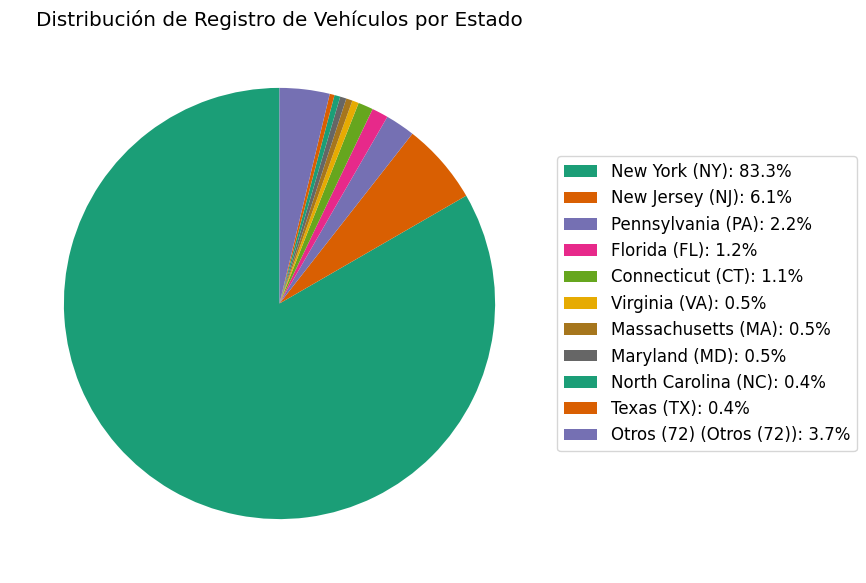

In [0]:
value_counts = dfp.groupby('STATE_REGISTRATION').size()

# Supongamos que 'value_counts' es tu serie de conteos de registros por estado
sorted_counts = value_counts.sort_values(ascending=False)
k = 10

# Obtener las 10 categorías más frecuentes
top_states = sorted_counts.head(k)

# Sumar los conteos de los estados que no están en los 10 más frecuentes y colocarlos en "Otros"
otros_count = sorted_counts[k:].sum()
top_states = top_states.append(pd.Series({f'Otros ({len(sorted_counts[k:])})': otros_count}))

# Calcular porcentaje de cada categoría
percentages = 100 * top_states / top_states.sum()

# Crear la figura y el gráfico
plt.figure(figsize=(9, 7))

# Definir una paleta de colores más oscura para las categorías más grandes
colors = plt.cm.Dark2.colors[:len(top_states)]


state_labels = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

labels = [state_labels.get(label, label) for label in top_states.index]


# Graficar el pastel sin porcentajes ni etiquetas
wedges, _ = plt.pie(percentages, labels=None, startangle=90, colors=colors)

# Añadir etiquetas fuera del pastel con nombres y porcentajes
label_texts = [f"{state_long_name} ({state}): {percentage:.1f}%" for state, percentage, state_long_name in zip(top_states.index, percentages, labels)]
plt.legend(wedges, label_texts, loc="center left", fontsize='large', bbox_to_anchor=(1, 0, 0.5, 1))

# Añadir título
plt.title("Distribución de Registro de Vehículos por Estado", fontsize='x-large')

# Mostrar el gráfico
plt.show()

In [0]:
# value_counts = dfp.groupby('STATE_REGISTRATION').size().sort_values(ascending=False)
# value_counts_2 = value_counts[1:]
# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts_2.values, labels=value_counts_2.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Registro del Vehículo por Estado")
# plt.tight_layout()
# plt.show()


In [0]:
#value_counts = df.groupBy('STATE_REGISTRATION').count()
#value_counts_pd = value_counts.toPandas()
#plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
#plt.pie(value_counts_pd['count'], labels=value_counts_pd['STATE_REGISTRATION'], autopct="%1.1f%%")  # Format as percentage
#plt.title("Registro del Vehículo por Estado")
#plt.tight_layout()
#plt.show()

# value_counts = dfp.groupby('STATE_REGISTRATION').size()

# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Registro del Vehículo por Estado")
# plt.tight_layout()
# plt.show()


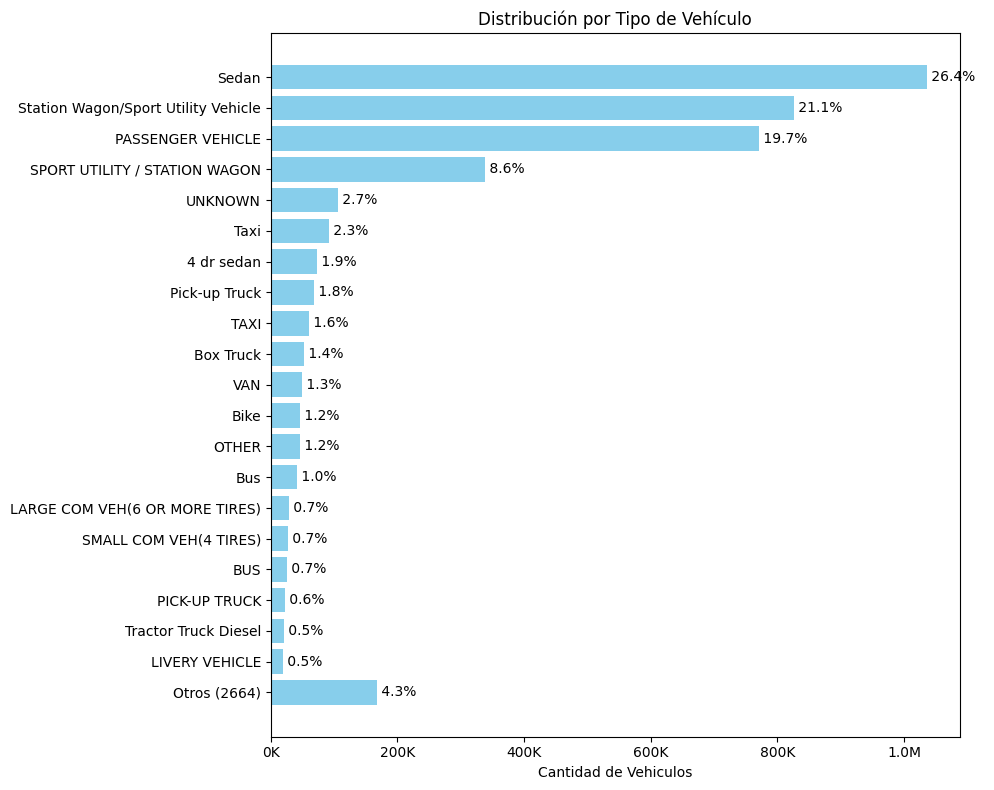

In [0]:
import matplotlib.ticker as ticker

# Supongamos que ya tienes definidas las variables value_counts y sorted_counts

# Obtener las 10 categorías más frecuentes
top_categories = sorted_counts.head(20)

# Sumar los conteos de las categorías que no están en las 10 más frecuentes y colocarlos en "Otros"
otros_count = sorted_counts[20:].sum()
top_categories[f'Otros ({len(sorted_counts[20:])})'] = otros_count

# Crear un gráfico de barras horizontales con las categorías organizadas de mayor a menor
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura según sea necesario
bars = plt.barh(top_categories.index, top_categories.values, color='skyblue')  # Gráfico de barras horizontal

plt.xlabel('Cantidad de Vehiculos')  # Etiqueta del eje x
plt.title('Distribución por Tipo de Vehículo')  # Título del gráfico
plt.gca().invert_yaxis()  # Invertir el eje y para que aparezcan los índices en orden descendente

# Cambiar el formato del eje x a mostrar K (miles) o M (millones)
formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}K'.format(x * 1e-3) if x < 1_000_000 else '{:.1f}M'.format(x * 1e-6))
plt.gca().xaxis.set_major_formatter(formatter)

# Mostrar los porcentajes en las barras
for bar in bars:
    yval = bar.get_height()  # Obtener la altura de la barra
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {bar.get_width() / sorted_counts.sum() * 100:.1f}%  ', 
             va='center')  # Mostrar el texto con el porcentaje

plt.tight_layout()  # Ajustar el diseño para evitar cortes
plt.show()

In [0]:

# value_counts = dfp.groupby('VEHICLE_TYPE').size()

# plt.figure(figsize=(16, 14))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Distribución por Tipo de Vehículo")
# plt.tight_layout()
# plt.show()

<Figure size 1300x1000 with 0 Axes>

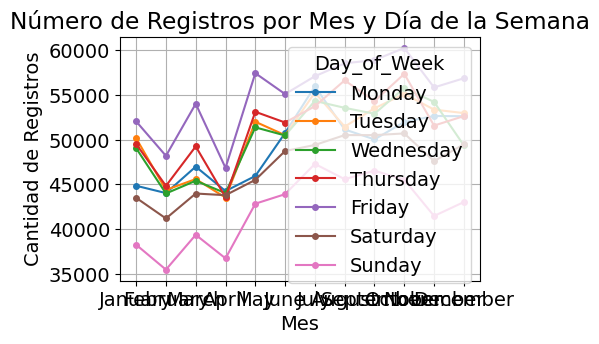

In [0]:
# Agrupar por mes y día de la semana
dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
dfp['Month'] = dfp['CRASH_DATE'].dt.month
dfp['Day_of_Week'] = dfp['CRASH_DATE'].dt.day_name()

# Calcular el conteo de registros por mes y día de la semana
register_count = dfp.groupby(['Month', 'Day_of_Week']).size().unstack()

# Ordenar los días de la semana en orden lógico
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
register_count = register_count.reindex(columns=days_order)

# Graficar
plt.figure(figsize=(13, 10))
register_count.plot(kind='line', marker='o', markersize=4, linestyle='-')
plt.title('Número de Registros por Mes y Día de la Semana')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])  # Para etiquetar meses
plt.grid(True)
plt.tight_layout(pad=4.0)  # Ajustar el espaciado general del gráficoplt.show()

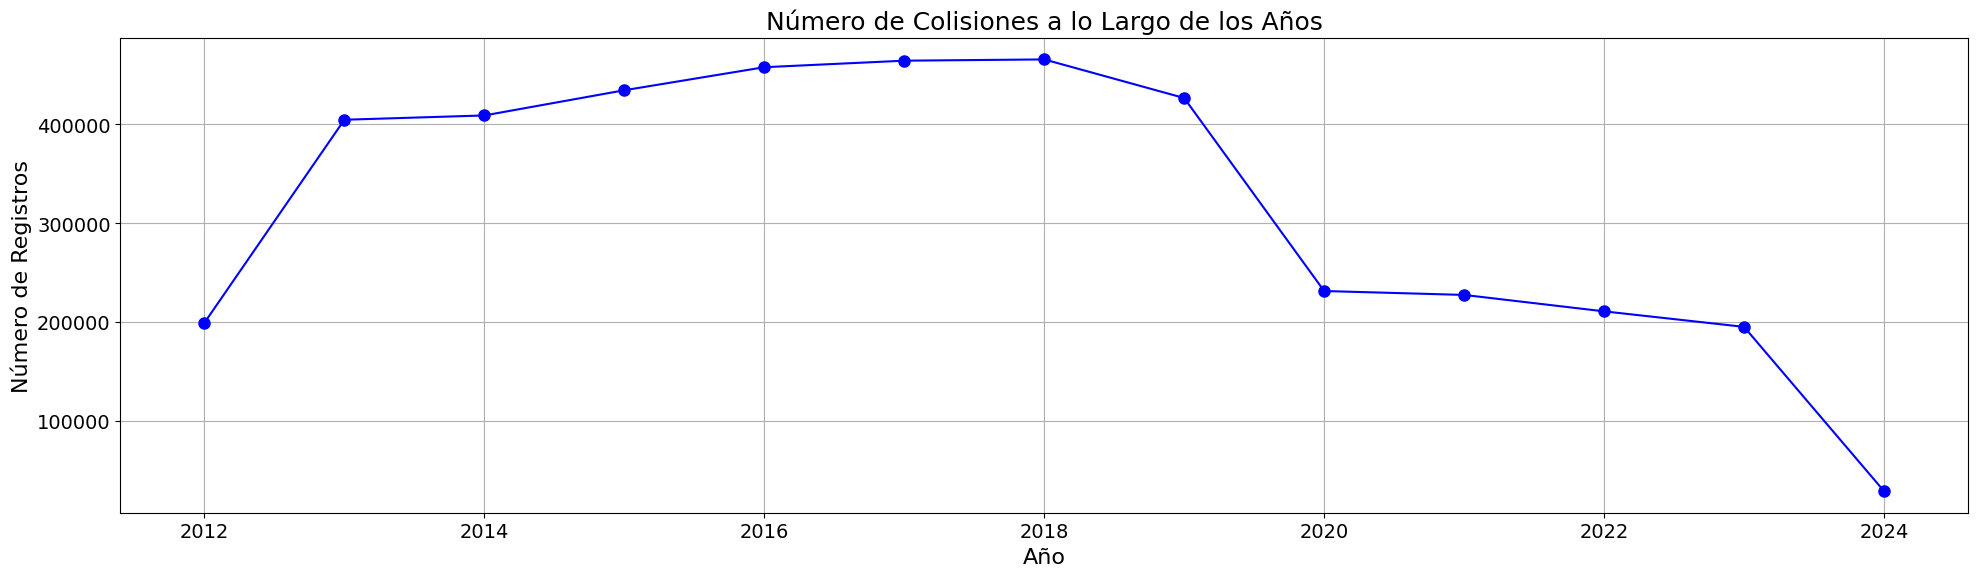

In [0]:
# Supongamos que `dfp` es tu DataFrame y `CRASH_DATE` es una columna de fechas
dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
register_count_by_year = dfp.groupby(dfp['CRASH_DATE'].dt.year).size()

# Establecer tamaño de la figura y ajustar el tamaño de la fuente
plt.figure(figsize=(20, 6))  # Ajusta el ancho y la altura de la figura según tus necesidades
plt.rcParams.update({'font.size': 14})  # Establece el tamaño de la fuente

# Graficar los datos
register_count_by_year.plot(kind='line', color='blue', marker='o', markersize=8, linestyle='-')

# Configurar título y etiquetas
plt.title('Número de Registros a lo Largo del Tiempo', fontsize=18)  # Título más grande
plt.xlabel('Año', fontsize=16)  # Etiqueta del eje x más grande
plt.ylabel('Número de Registros', fontsize=16)  # Etiqueta del eje y más grande
plt.grid(True)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

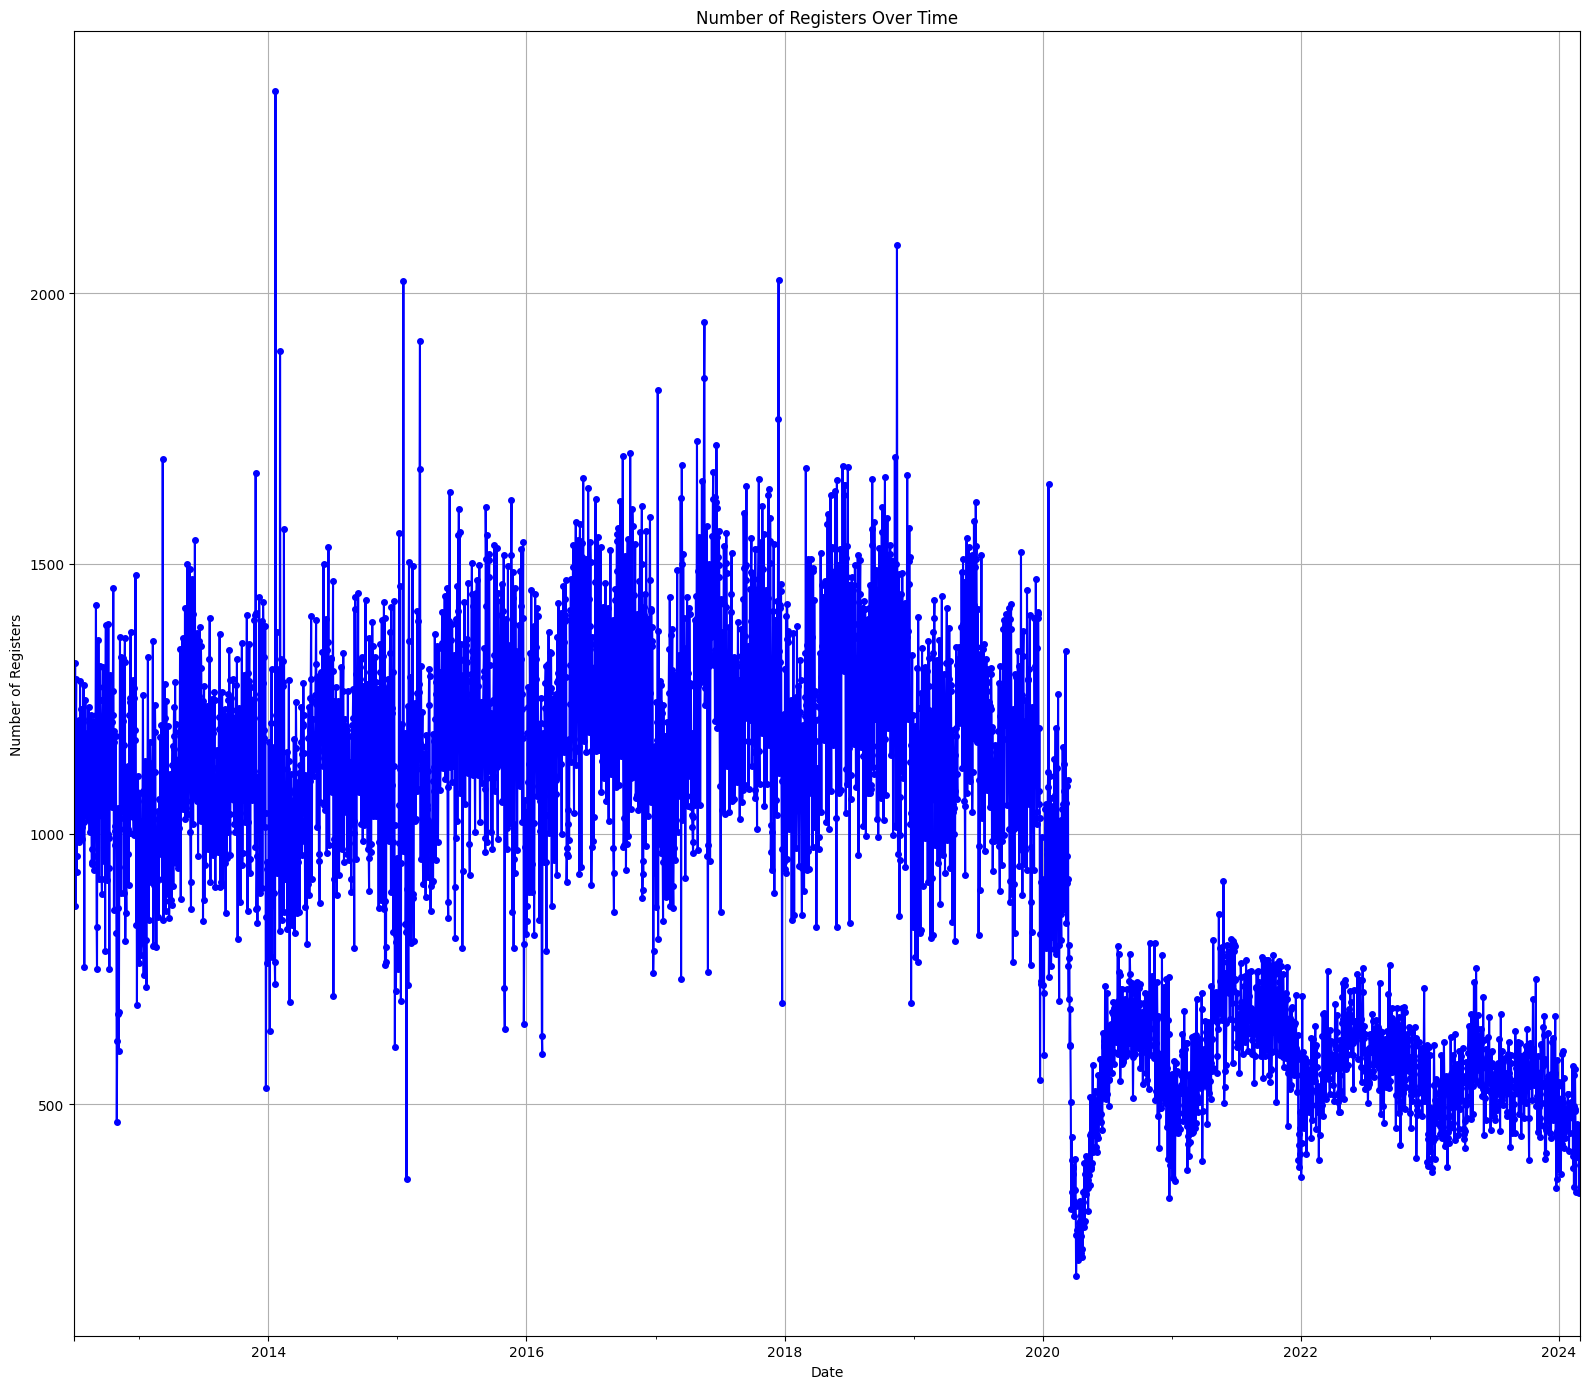

In [0]:
# dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
# register_count = dfp.groupby('CRASH_DATE').size()


# plt.figure(figsize=(16, 14))
# register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')
# plt.title('Number of Registers Over Time')
# plt.xlabel('Date')
# plt.ylabel('Number of Registers')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

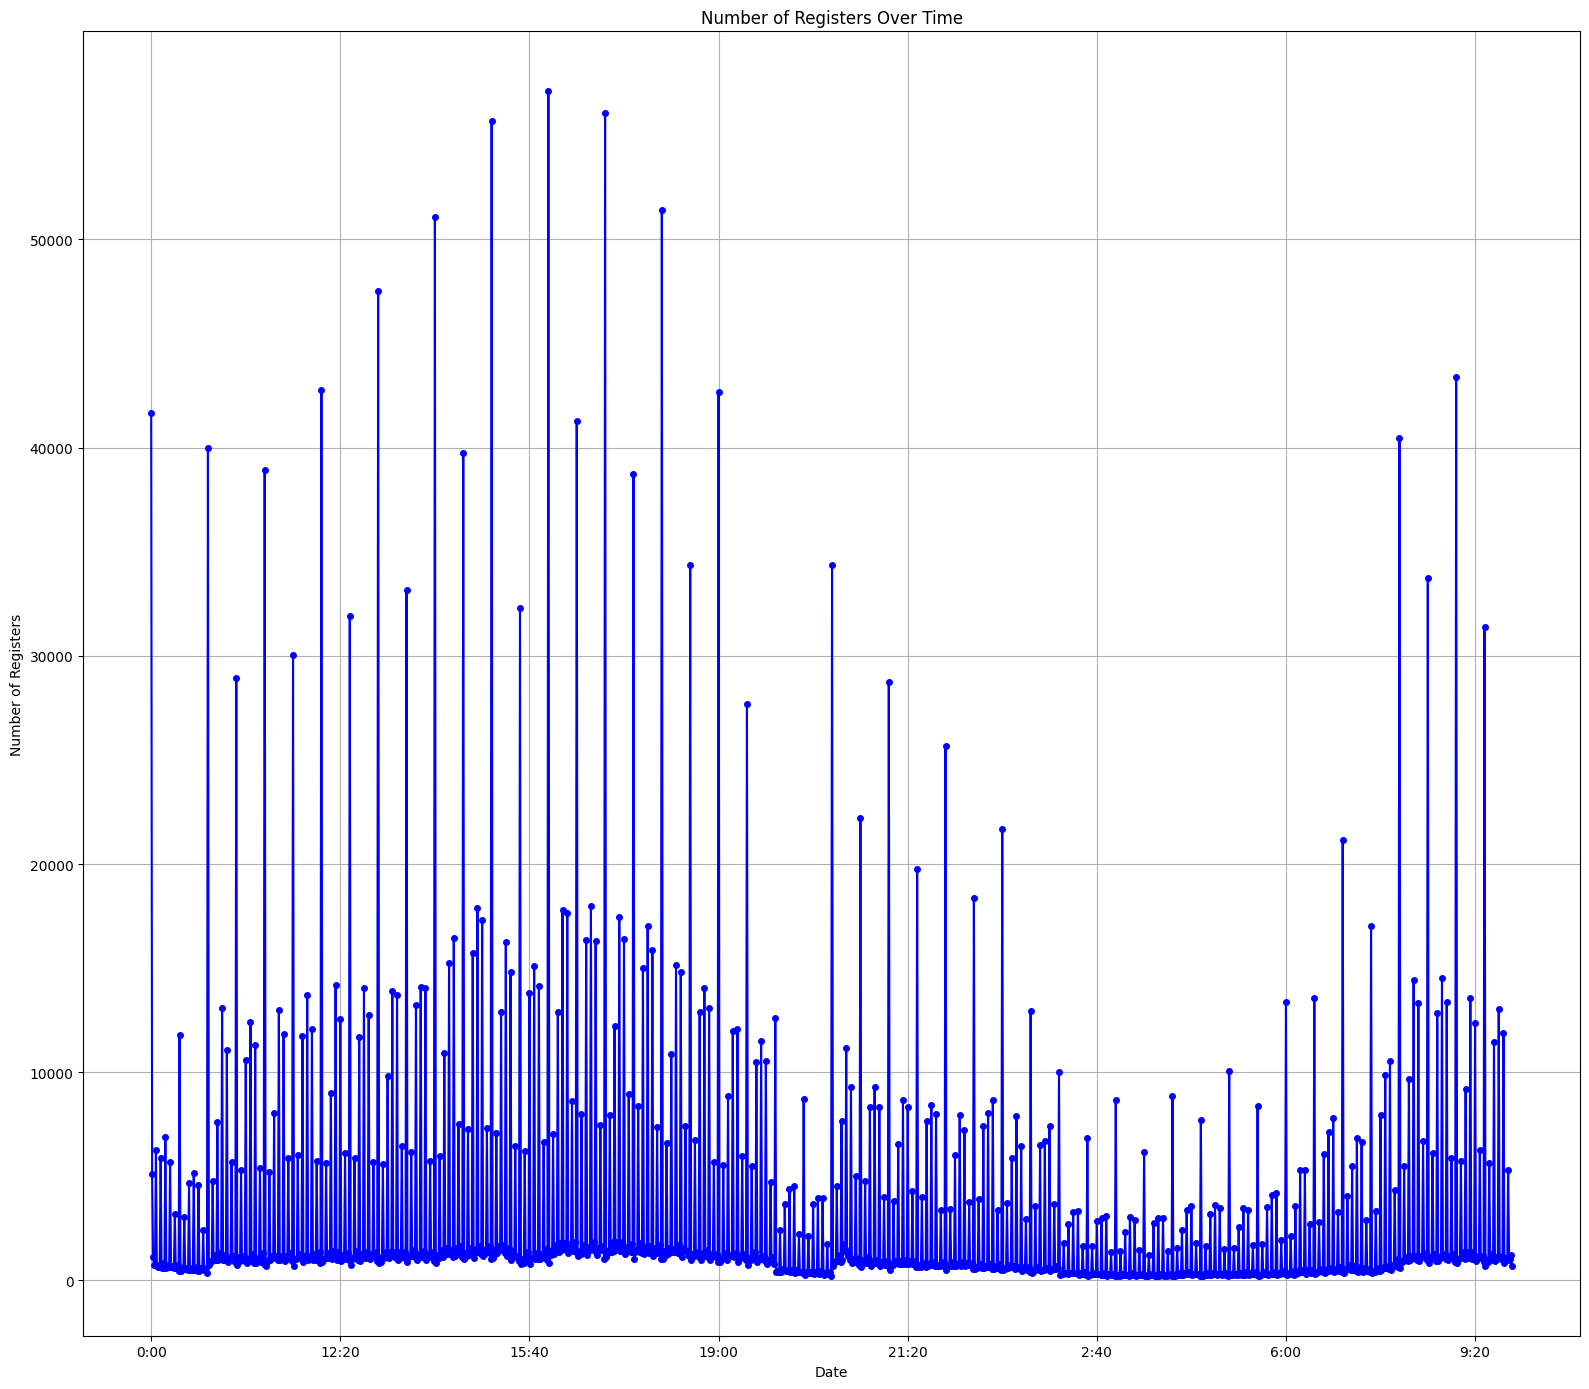

In [0]:
register_count = dfp.groupby('CRASH_TIME').size()

plt.figure(figsize=(16, 14))
register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')
plt.title('Number of Registers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Registers')
plt.grid(True)
plt.tight_layout()
plt.show()

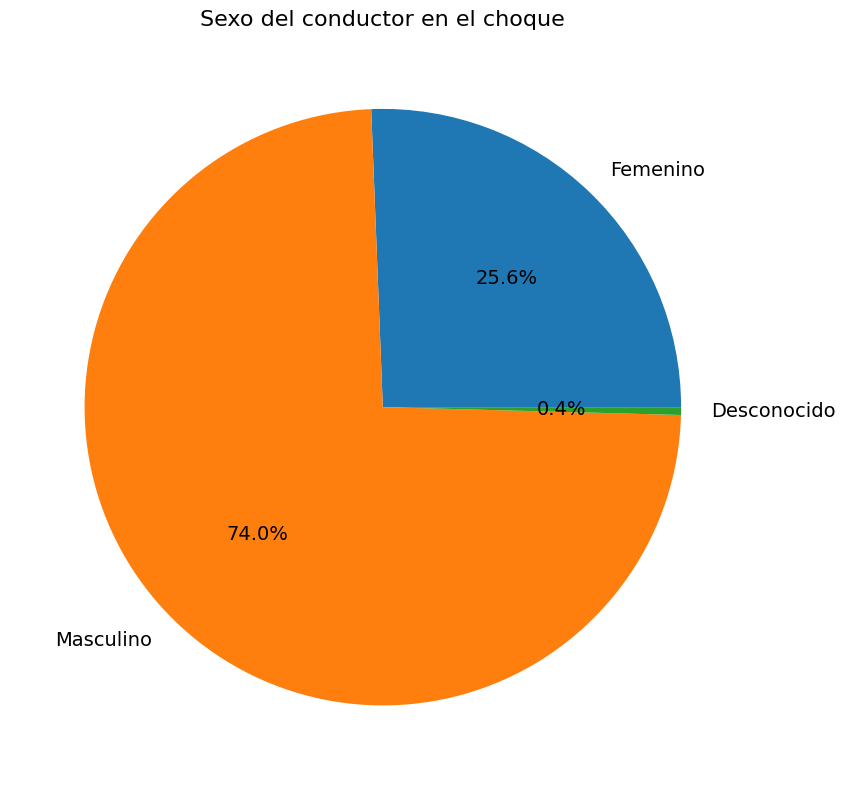

In [0]:
# Calcular value_counts para PERP_SEX
value_counts = dfp.groupby('DRIVER_SEX').size()

# Renombrar las etiquetas según tus especificaciones
gender_labels = {'F': 'Femenino', 'M': 'Masculino', 'U': 'Desconocido'}
labels = [gender_labels.get(label, label) for label in value_counts.index]

# Configurar el tamaño del gráfico y otros parámetros
plt.figure(figsize=(10, 8))  # Ajustar el tamaño según sea necesario
plt.pie(value_counts.values, labels=labels, autopct="%1.1f%%", textprops={'fontsize': 14})  # Ajustar el tamaño del texto
plt.title("Sexo del conductor en el choque", fontsize=16)  # Ajustar el título
plt.tight_layout()

# Mostrar el gráfico
plt.show()

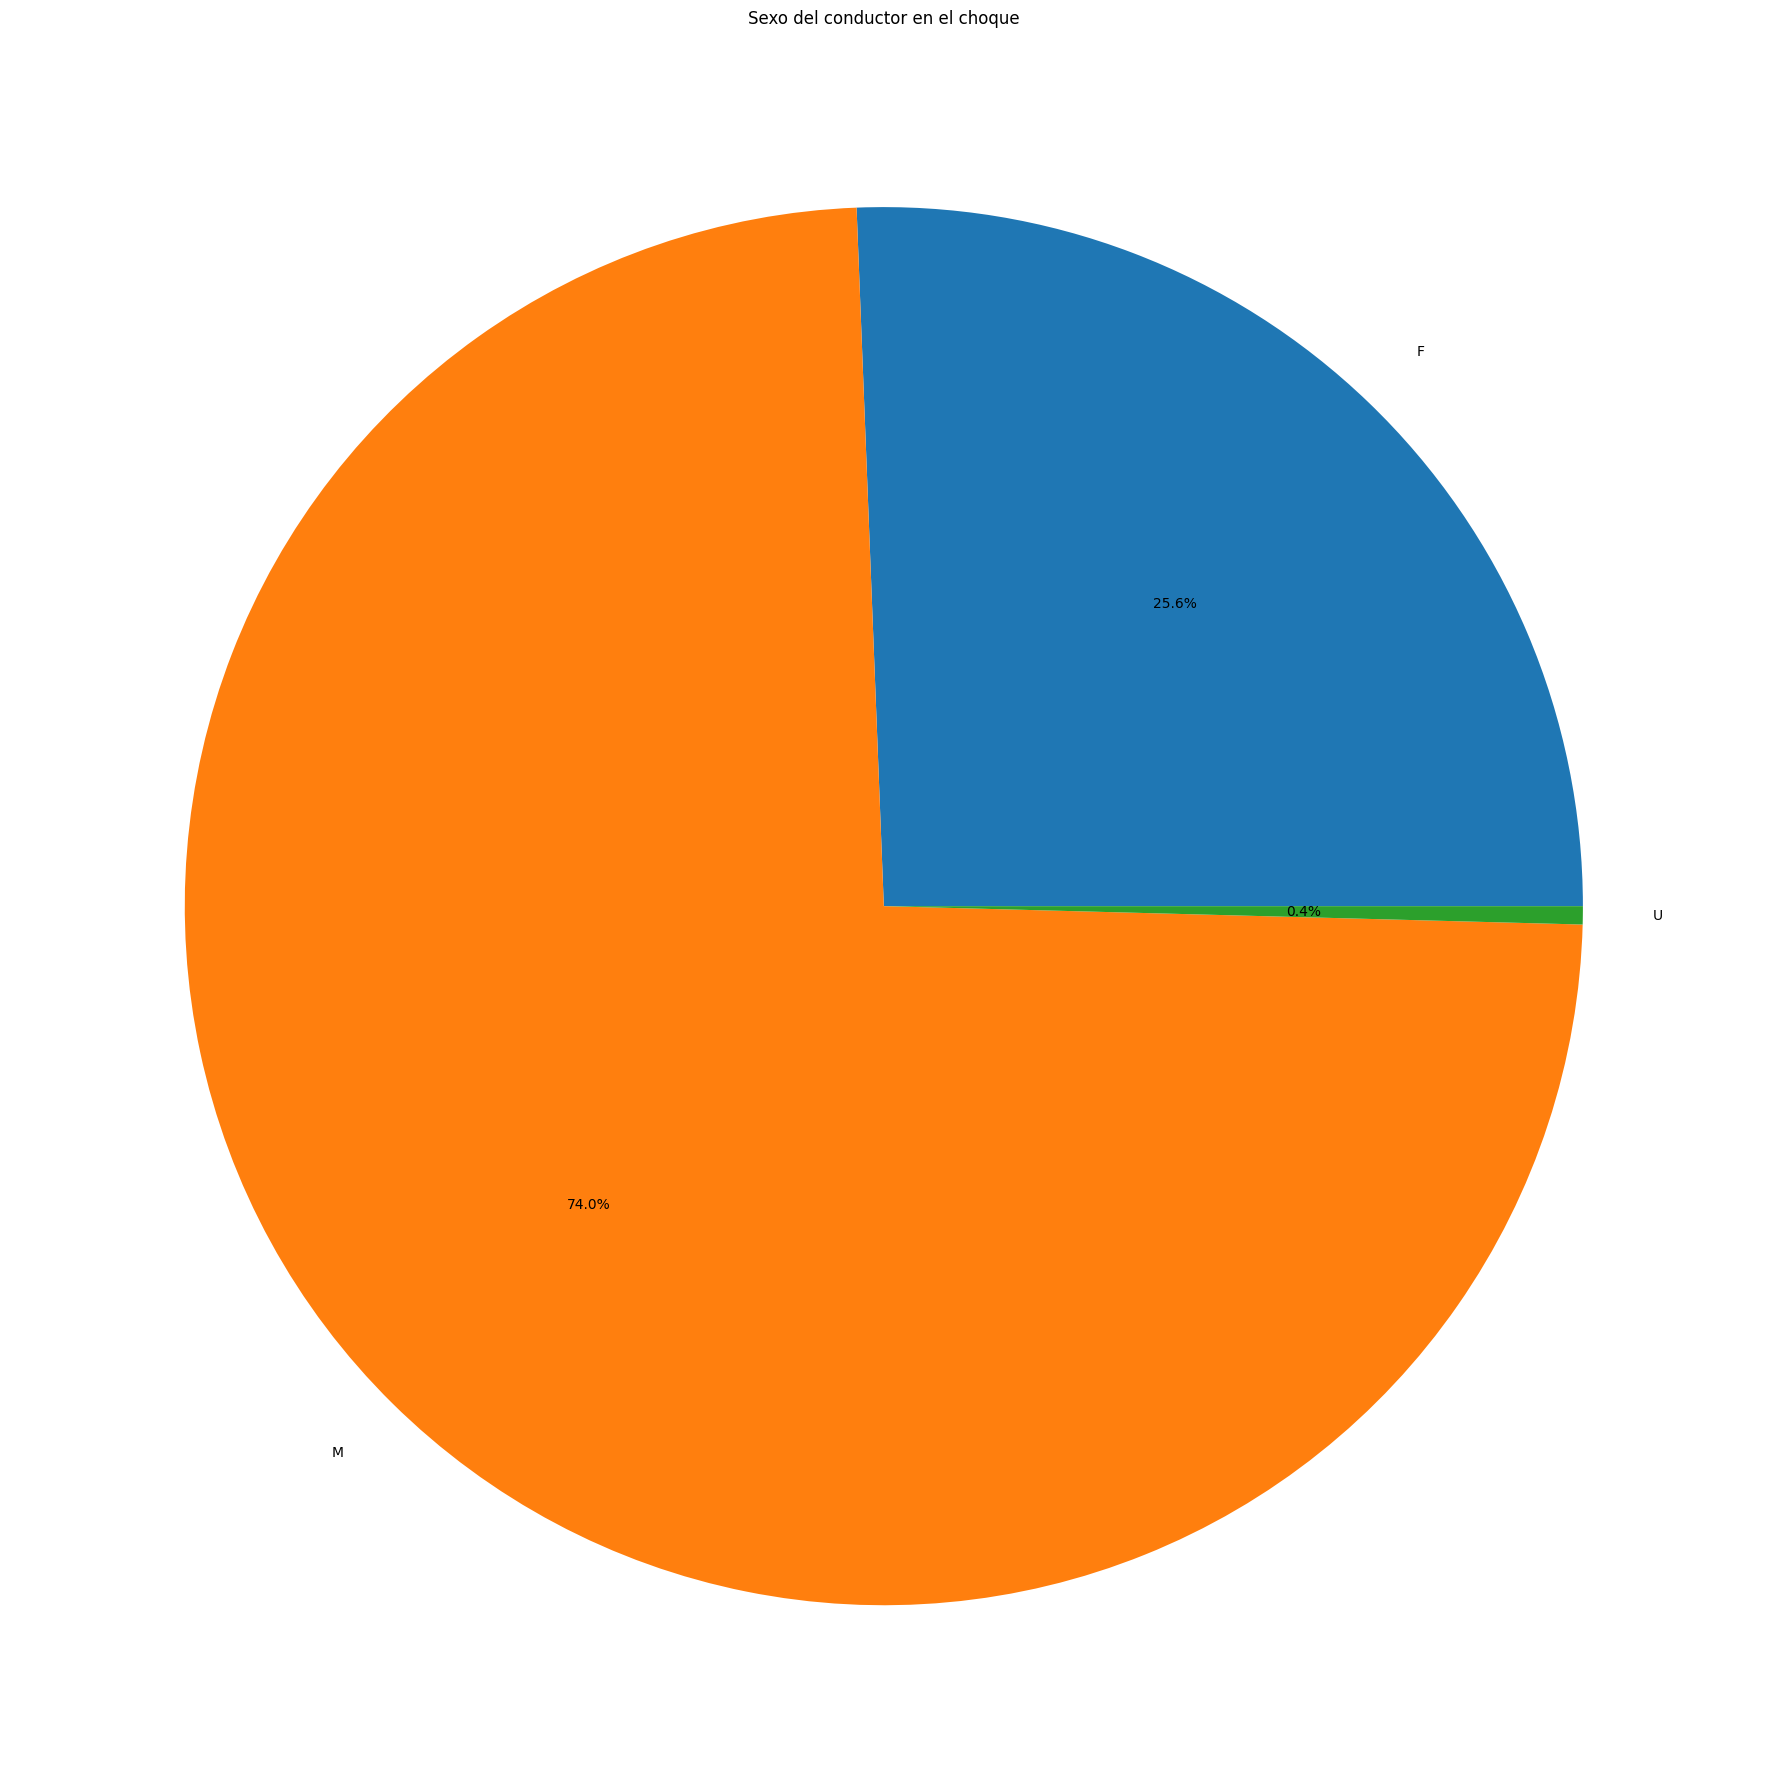

In [0]:

# value_counts = dfp.groupby('DRIVER_SEX').size()

# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Sexo del conductor en el choque")
# plt.tight_layout()
# plt.show()

#Eliminación de valores nulos




In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *

pairs = df.select("STATE_REGISTRATION", "DRIVER_LICENSE_JURISDICTION").distinct() \
    .filter(df.STATE_REGISTRATION.isNotNull() & df.DRIVER_LICENSE_JURISDICTION.isNotNull()).collect()

# Construct a dictionary to store the relations
relations_dict = {}
for row in pairs:
    pd_cd = row["STATE_REGISTRATION"]
    ky_cd = row["DRIVER_LICENSE_JURISDICTION"]
    if pd_cd not in relations_dict:
        relations_dict[pd_cd] = ky_cd

# Print the dictionary
print("Relations:")
for pd_cd, ky_cd in relations_dict.items():
    print(f"STATE_REGISTRATION: {pd_cd} -> DRIVER_LICENSE_JURISDICTION: {ky_cd}")

# Broadcast the dictionary
broadcasted_dict = spark.sparkContext.broadcast(relations_dict)

# UDF to fill null values
def fill_null_with_dict(value):
    relations_dict = broadcasted_dict.value
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(fill_null_with_dict, StringType())

# Apply UDF to fill null values
df_filled = df.withColumn("DRIVER_LICENSE_JURISDICTION", 
                          when(col("DRIVER_LICENSE_JURISDICTION").isNull(), 
                               fill_null_with_dict_udf(col("STATE_REGISTRATION"))
                              ).otherwise(col("DRIVER_LICENSE_JURISDICTION")))

# Count null values in DRIVER_LICENSE_JURISDICTION
nulls_count_ky_cd = df_filled.filter(col("DRIVER_LICENSE_JURISDICTION").isNull()).count()

# Print the count
print("Number of null values in KY_CD:", nulls_count_ky_cd)

# Show DataFrame
df = df_filled

Relations:
STATE_REGISTRATION: DC -> DRIVER_LICENSE_JURISDICTION: NC
STATE_REGISTRATION: SC -> DRIVER_LICENSE_JURISDICTION: PA
STATE_REGISTRATION: MN -> DRIVER_LICENSE_JURISDICTION: IL
STATE_REGISTRATION: IN -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: ME -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: NB -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: CT -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: MO -> DRIVER_LICENSE_JURISDICTION: MO
STATE_REGISTRATION: OK -> DRIVER_LICENSE_JURISDICTION: TX
STATE_REGISTRATION: OH -> DRIVER_LICENSE_JURISDICTION: CT
STATE_REGISTRATION: PA -> DRIVER_LICENSE_JURISDICTION: MX
STATE_REGISTRATION: ID -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: GA -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: NJ -> DRIVER_LICENSE_JURISDICTION: TN
STATE_REGISTRATION: RI -> DRIVER_LICENSE_JURISDICTION: CA
STATE_REGISTRATION: NC -> DRIVER_LICENSE_JURISDICTION: ND
STATE_REGISTRATION: FL -> DRIVER_LICENSE_JURISDICTION: CA
STA

In [0]:
#Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()


relations_dict = {}
for row in pairs:
    vehicle_type = row["VEHICLE_TYPE"]
    model = row["MODEL"]
    if vehicle_type not in relations_dict:
        relations_dict[vehicle_type] = []
    relations_dict[vehicle_type].append(model)

# Print the dictionary
print("Relations:")
for vehicle_type, model_list in relations_dict.items():
    print(f"VEHICLE_TYPE: {vehicle_type} -> MODEL: {model_list}")

def fill_null_with_dict(value, relations_dict):
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(lambda x: fill_null_with_dict(x, relations_dict), StringType())


df_filled = df.withColumn("MODEL", when(col("MODEL").isNull(), fill_null_with_dict_udf(col("VEHICLE_TYPE"))).otherwise(col("MODEL")))

nulls_count_ky_cd = df_filled.filter(col("MODEL").isNull()).count()

# Print the count
print("Number of null values in MODEL:", nulls_count_ky_cd)

df = df_filled

Relations:
VEHICLE_TYPE: Taxi -> MODEL: ['CAR/SUV', 'BUS', ' SHORT YELLOW SCHOOL BUS', 'TAXI', 'TL', 'BU', '1']
VEHICLE_TYPE: Pick-up Truck -> MODEL: [' TRUCK', ' UNKNOWN', 'CAR/SUV', ' DUMP', 'TRUCK', 'HAUL', '', 'FLATBED TRUCK', '70', 'UP TRUCK', 'up', 'DELIVERY', 'UP', '106', 'NATION', 'TRACTOR TRAILER', 'UTILIM', 'TRUCK/BUS', 'FREIGHT', ' UD', ' DELIVERY TRUCK', ' TRACTOR TRAILER', '999', 'ex', 'LITE', 'TK', ' TRAC', '150XLT PICK UP TRUCK', '150']
VEHICLE_TYPE: CRANE -> MODEL: ['54 SERIAL: 17356']
VEHICLE_TYPE: Motorscooter -> MODEL: ['MCL', 'BIKE', 'Bike', 'G ELECTRIC SCOOTER', '1', ' MOTORCYCLE', '4X', '4', '5', 'PRO SCOOTER', 'S3', 'PRO', 'FLY', 'E Bike', 'WING', '16A']
VEHICLE_TYPE: Bus -> MODEL: ['TRUCK/BUS', 'Int', 'UNK', 'TE', ' GREY HOUND', ' Nova', 'int', 'OMNIBUS', 'fl', 'HYBRID', 'BIR', ' BUS', 'FL', ' Star City', '45', 'INT', 'TR', 'bu', 'BUS', 'BU', 'Reynolds Corp.', 'Intl', 'CRAFT', 'REYNOLDS CORP', 'intl', 'YELLOW BUS', 'MTA BUS', ' YELLOW BUS', ' LFS', 'TRANSIT', '1

#Limpieza de Datos




### Inputación de datos en la columnas 'DRIVER_LICENSE_JURISDICTION' basado en valores de la columna 'STATE_REGISTRATION'

En este apartado se crea un diccionario en dónde se va a almacenar los valores equivalente de STATE_REGISTRATION para DRIVER_LICENSE_JURISDICTION debido a que esta última columna cuenta con más valores nulos que la primera. Con esto se espera que al momento de haber un nulo en DRIVER_LICENSE_JURISDICTION, este sea rellenado usando un diccionario que almacena una "tabla de equivalencias" entre los valores de STATE_REGISTRATION y DRIVER_LICENSE_JURISDICTION. Por ejemplo digamos que el diccionario alamcena que {NY: NY, DC: DC} y encuentra que el valor en DRIVER_LICENSE_JURISDICTION es nulo pero que en STATE_REGISTRATION es NY, entonces va a reemplazar el valor faltante por NY. 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *

pairs = df.select("STATE_REGISTRATION", "DRIVER_LICENSE_JURISDICTION").distinct() \
    .filter(df.STATE_REGISTRATION.isNotNull() & df.DRIVER_LICENSE_JURISDICTION.isNotNull()).collect()

# Construct a dictionary to store the relations
relations_dict = {}
for row in pairs:
    pd_cd = row["STATE_REGISTRATION"]
    ky_cd = row["DRIVER_LICENSE_JURISDICTION"]
    if pd_cd not in relations_dict:
        relations_dict[pd_cd] = ky_cd

# Print the dictionary
print("Relations:")
for pd_cd, ky_cd in relations_dict.items():
    print(f"STATE_REGISTRATION: {pd_cd} -> DRIVER_LICENSE_JURISDICTION: {ky_cd}")

# Broadcast the dictionary
broadcasted_dict = spark.sparkContext.broadcast(relations_dict)

# UDF to fill null values
def fill_null_with_dict(value):
    relations_dict = broadcasted_dict.value
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(fill_null_with_dict, StringType())

# Apply UDF to fill null values
df_filled = df.withColumn("DRIVER_LICENSE_JURISDICTION", 
                          when(col("DRIVER_LICENSE_JURISDICTION").isNull(), 
                               fill_null_with_dict_udf(col("STATE_REGISTRATION"))
                              ).otherwise(col("DRIVER_LICENSE_JURISDICTION")))

# Count null values in DRIVER_LICENSE_JURISDICTION
nulls_count_ky_cd = df_filled.filter(col("DRIVER_LICENSE_JURISDICTION").isNull()).count()

# Print the count
print("Number of null values in KY_CD:", nulls_count_ky_cd)

# Show DataFrame
df = df_filled

Relations:
STATE_REGISTRATION: DC -> DRIVER_LICENSE_JURISDICTION: NC
STATE_REGISTRATION: SC -> DRIVER_LICENSE_JURISDICTION: PA
STATE_REGISTRATION: MN -> DRIVER_LICENSE_JURISDICTION: IL
STATE_REGISTRATION: IN -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: ME -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: NB -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: CT -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: MO -> DRIVER_LICENSE_JURISDICTION: MO
STATE_REGISTRATION: OK -> DRIVER_LICENSE_JURISDICTION: TX
STATE_REGISTRATION: OH -> DRIVER_LICENSE_JURISDICTION: CT
STATE_REGISTRATION: PA -> DRIVER_LICENSE_JURISDICTION: MX
STATE_REGISTRATION: ID -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: GA -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: NJ -> DRIVER_LICENSE_JURISDICTION: TN
STATE_REGISTRATION: RI -> DRIVER_LICENSE_JURISDICTION: CA
STATE_REGISTRATION: NC -> DRIVER_LICENSE_JURISDICTION: ND
STATE_REGISTRATION: FL -> DRIVER_LICENSE_JURISDICTION: CA
STA

### Inputación de datos en la columnas 'VEHICLE_TYPE' basado en valores de la columna 'MODEL'

El proceso que se hizo es análogo al que se hizo en la anterior celda

In [0]:
#Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()


relations_dict = {}
for row in pairs:
    vehicle_type = row["VEHICLE_TYPE"]
    model = row["MODEL"]
    if vehicle_type not in relations_dict:
        relations_dict[vehicle_type] = []
    relations_dict[vehicle_type].append(model)

# Print the dictionary
print("Relations:")
for vehicle_type, model_list in relations_dict.items():
    print(f"VEHICLE_TYPE: {vehicle_type} -> MODEL: {model_list}")

def fill_null_with_dict(value, relations_dict):
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(lambda x: fill_null_with_dict(x, relations_dict), StringType())


df_filled = df.withColumn("MODEL", when(col("MODEL").isNull(), fill_null_with_dict_udf(col("VEHICLE_TYPE"))).otherwise(col("MODEL")))

nulls_count_ky_cd = df_filled.filter(col("MODEL").isNull()).count()

# Print the count
print("Number of null values in MODEL:", nulls_count_ky_cd)

df = df_filled

### Separación de la columna 'VEHICLE_MAKE'

Se separa esta columan con el fin de poder separar el modelo del auto (la marca de este) y el tipo de auto que es (CAR/SUV, SEDAN, entre otros)

In [0]:
from pyspark.sql.functions import split

# Split the VEHICLE_MAKE
df = df.withColumn("MAKE", split(df["VEHICLE_MAKE"], "-")[0]) \
       .withColumn("MODEL", split(df["VEHICLE_MAKE"], "-")[1])

# Drop  VEHICLE_MAKE 

# Stop the SparkSession
df.limit(5).toPandas()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_MODEL,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,PUBLIC_PROPERTY_DAMAGE,PUBLIC_PROPERTY_DAMAGE_TYPE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,MAKE,MODEL
0,10385780,100201,09/07/2012,9:03,1,NY,PASSENGER VEHICLE,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Unspecified,None,None,None
1,19140702,4213082,09/23/2019,8:15,0553ab4d-9500-4cba-8d98-f4d7f89d5856,NY,Station Wagon/Sport Utility Vehicle,None,2002,North,1,M,Licensed,NY,Going Straight Ahead,Left Front Bumper,Left Front Quarter Panel,None,None,None,N,None,Driver Inattention/Distraction,Unspecified,TOYT,CAR/SUV
2,14887647,3307608,10/02/2015,17:18,2,NY,TAXI,None,None,None,None,None,None,None,Going Straight Ahead,None,None,None,None,None,None,None,Driver Inattention/Distraction,None,None,None
3,14889754,3308693,10/04/2015,20:34,1,NY,PASSENGER VEHICLE,None,None,None,None,None,None,None,Parked,None,None,None,None,None,None,None,Unspecified,None,None,None
4,14400270,297666,04/25/2013,21:15,1,NY,PASSENGER VEHICLE,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Other Vehicular,None,None,None


### Eliminación de columnas

In [0]:
#Se elimina la columna model porque la columnas Vehicle type aporta la misma información con menor cantidad de nulos
df = df.drop('MODEL')
# Se van a eliminar las siguientes columnas debido a que no se van a usar para el análisis
df = df.drop("VEHICLE_MAKE")
df = df.drop('UNIQUE_ID')
df = df.drop('VEHICLE_ID')
df = df.drop('PUBLIC_PROPERTY_DAMAGE')
df = df.drop('PUBLIC_PROPERTY_DAMAGE_TYPE')
df = df.drop('VEHICLE_MODEL')


### Estandarización de la columna CRASH_TIME

Lo primero que se hizo fue convertir las horas a que estas pertenezcan a 'una hora específica', es decir, ahora ya no se van a contar con horas que terminen en números diferentes a cero y solo se van a contar con las horas :00 o las horas :30. En este sentido algo que se encuentre en las horas :00 es una hroa que esté entre las :46 y las y 15, mientras que algo que se encuentre en las horas :30 son hroas que están entre las :16 y las :45. 

In [0]:
def round_time(time):
    hour, minute = map(int, time.split(':'))
    if 15 < minute <= 45:
        minute = 30
    else:
        minute = 0
        if minute == 0 and hour == 23:
            hour = 0
        else:
            hour = (hour + 1) if minute == 0 else hour
    return f"{hour:02d}:{minute:02d}"
    
print(round_time('10:29')) 

# Register UDF
round_time_udf = udf(round_time, StringType())

# Apply UDF to CRASH_TIME column
df = df.withColumn("CRASH_TIME", round_time_udf("CRASH_TIME"))
df.limit(4).toPandas()


,COLLISION_ID,CRASH_DATE,CRASH_TIME,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,MAKE
0,100201,09/07/2012,9:00,NY,PASSENGER VEHICLE,None,None,None,None,None,OH,None,None,None,None,None,None,Unspecified,None,None
1,4213082,09/23/2019,8:00,NY,Station Wagon/Sport Utility Vehicle,2002,North,1,M,Licensed,NY,Going Straight Ahead,Left Front Bumper,Left Front Quarter Panel,None,None,None,Driver Inattention/Distraction,Unspecified,TOYT
2,3307608,10/02/2015,17:00,NY,TAXI,None,None,None,None,None,OH,Going Straight Ahead,None,None,None,None,None,Driver Inattention/Distraction,None,None
3,3308693,10/04/2015,20:30,NY,PASSENGER VEHICLE,None,None,None,None,None,OH,Parked,None,None,None,None,None,Unspecified,None,None


In [0]:
def round_time(time):
    hour, minute = map(int, time.split(':'))
    if 15 < minute <= 45:
        minute = 30
    else:
        minute = 0
        if minute == 0 and hour == 23:
            hour = 0
        else:
            hour = (hour + 1) if minute == 0 else hour
    return f"{hour:02d}:{minute:02d}"
    
print(round_time('10:29')) 


# Apply function to CRASH_TIME column
dfp['CRASH_TIME'] = dfp['CRASH_TIME'].apply(round_time)

# Show the result
display(dfp)



### Creación de columnas basadas en los atributros de VEHICLE_DAMAGE, VEHICLE_DAMAGE_1, VEHICLE_DAMAGE_2 y VEHICLE_DAMAGE_3

Debido a que estas columnas cuentan con una enorme cantidad de valores nulos y también por el hecho de contienen los mismos datos valores para los datos, se decidió a partir de los valores de estos datos crear las columnas, después llenarlas utilizando los valores que tengan los VEHICLE_DAMAGE en esa fila por medio de valores binarios, 1 si contiene ese valor en alguna de las VEHICLE_DAMAGE, 0 si no.Posteriormente se hará la eliminación de estas columnas de VEHICLE_DAMAGE.


In [0]:
distinct_values = df.select('VEHICLE_DAMAGE_1').distinct().collect()
distinct_values2 = df.select('VEHICLE_DAMAGE_2').distinct().collect()
distinct_values3 = df.select('VEHICLE_DAMAGE_3').distinct().collect()



# Print distinct values
print(f"All distinct values in column '{'Vehicle_Damage'}':")
for row in distinct_values:
    print(row["VEHICLE_DAMAGE_1"])

for row in distinct_values2:
    print(row['VEHICLE_DAMAGE_2'])

for row in distinct_values3:
    print(row['VEHICLE_DAMAGE_3'])


All distinct values in column 'Vehicle_Damage':
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage


In [0]:
# List of unique values
df_copy2 = df
unique_values = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel", "None", "Right Front Bumper",
    "Left Rear Bumper", "Right Side Doors", "Roof", "Right Front Quarter Panel", "Other", "Overturned",
    "Trailer", "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper", "Demolished", "Center Front End",
    "Undercarriage", "Right Rear Bumper", "No Damage"
]

# Create new columns for each unique value and populate them based on the original column
for value in unique_values:
    df_copy2 = df_copy2.withColumn(value.replace(" ", "_"), when(df_copy2["VEHICLE_DAMAGE_1"] == value, 1).otherwise(0))

df_copy2.limit(5).toPandas()

,COLLISION_ID,CRASH_DATE,CRASH_TIME,STATE_REGISTRATION,VEHICLE_TYPE,VEHICLE_YEAR,TRAVEL_DIRECTION,VEHICLE_OCCUPANTS,DRIVER_SEX,DRIVER_LICENSE_STATUS,DRIVER_LICENSE_JURISDICTION,PRE_CRASH,POINT_OF_IMPACT,VEHICLE_DAMAGE,VEHICLE_DAMAGE_1,VEHICLE_DAMAGE_2,VEHICLE_DAMAGE_3,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,MAKE,Left_Rear_Quarter_Panel,Center_Back_End,Left_Front_Quarter_Panel,None,Right_Front_Bumper,Left_Rear_Bumper,Right_Side_Doors,Roof,Right_Front_Quarter_Panel,Other,Overturned,Trailer,Right_Rear_Quarter_Panel,Left_Side_Doors,Left_Front_Bumper,Demolished,Center_Front_End,Undercarriage,Right_Rear_Bumper,No_Damage
0,100201,09/07/2012,9:00,NY,PASSENGER VEHICLE,None,None,None,None,None,OH,None,None,None,None,None,None,Unspecified,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4213082,09/23/2019,8:00,NY,Station Wagon/Sport Utility Vehicle,2002,North,1,M,Licensed,NY,Going Straight Ahead,Left Front Bumper,Left Front Quarter Panel,None,None,None,Driver Inattention/Distraction,Unspecified,TOYT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3307608,10/02/2015,17:00,NY,TAXI,None,None,None,None,None,OH,Going Straight Ahead,None,None,None,None,None,Driver Inattention/Distraction,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3308693,10/04/2015,20:30,NY,PASSENGER VEHICLE,None,None,None,None,None,OH,Parked,None,None,None,None,None,Unspecified,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,297666,04/25/2013,21:00,NY,PASSENGER VEHICLE,None,None,None,None,None,OH,None,None,None,None,None,None,Other Vehicular,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE"] == damage_type), 1)
                       .otherwise(0))



In [0]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_1"] == damage_type), 1)
                       .otherwise(0))


In [0]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_2"] == damage_type), 1)
                       .otherwise(0))



In [0]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_3"] == damage_type), 1)
                       .otherwise(0))


In [0]:
df.filter(col('VEHICLE_DAMAGE').isNotNull()).toPandas()

In [0]:
#Verificando que haya funcionado el cambio de valores a columnas binarias
df.filter(col('VEHICLE_DAMAGE_1').isNotNull()).toPandas()



In [0]:
df.filter(col('VEHICLE_DAMAGE_2').isNotNull()).toPandas()


In [0]:
df.filter(col('VEHICLE_DAMAGE_3').isNotNull()).toPandas()


### Estandarización de variables
Se estandariza la fecha del choque a el tipo fecha, al igual que se pone en formato de tiempos la hora del accidente,el número de ocupantes se convierte a un valor entero y por último, se crea la columna CRASH_YEAR la cuál va a tomar el año de la fecha del accidente y la va a almacenar dentro de sí. 

In [0]:
df = df.withColumn('CRASH_DATE', to_date(df['CRASH_DATE'], 'MM/dd/yyyy' ))
df = df.withColumn('CRASH_TIME', to_timestamp(df['CRASH_TIME'], 'HH:mm'))
df = df.withColumn('VEHICLE_OCCUPANTS', col('VEHICLE_OCCUPANTS').cast('integer'))

df.dtypes

[('UNIQUE_ID', 'string'),
 ('COLLISION_ID', 'string'),
 ('CRASH_DATE', 'date'),
 ('CRASH_TIME', 'timestamp'),
 ('VEHICLE_ID', 'string'),
 ('STATE_REGISTRATION', 'string'),
 ('VEHICLE_TYPE', 'string'),
 ('VEHICLE_MAKE', 'string'),
 ('VEHICLE_MODEL', 'string'),
 ('VEHICLE_YEAR', 'string'),
 ('TRAVEL_DIRECTION', 'string'),
 ('VEHICLE_OCCUPANTS', 'int'),
 ('DRIVER_SEX', 'string'),
 ('DRIVER_LICENSE_STATUS', 'string'),
 ('DRIVER_LICENSE_JURISDICTION', 'string'),
 ('PRE_CRASH', 'string'),
 ('POINT_OF_IMPACT', 'string'),
 ('VEHICLE_DAMAGE', 'string'),
 ('VEHICLE_DAMAGE_1', 'string'),
 ('VEHICLE_DAMAGE_2', 'string'),
 ('VEHICLE_DAMAGE_3', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE_TYPE', 'string'),
 ('CONTRIBUTING_FACTOR_1', 'string'),
 ('CONTRIBUTING_FACTOR_2', 'string')]

In [0]:
from pyspark.sql.functions import year, col
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Assuming your DataFrame is named df
# Assuming you have SparkSession named spark

# Extract the year from the 'CRASH_DATE' column
df_with_year = df.withColumn('CRASH_YEAR', year(col('CRASH_DATE')))

# Define a list of columns for which you want to check null values
columns_to_check = df.columns

# Define an empty dictionary to store results
result_matrix = {}

# Iterate through each column and calculate the number of null values for each year
for column in columns_to_check:
    result_matrix[column] = (
        df_with_year
        .filter(col(column).isNull())  # Filter null values
        .groupBy('CRASH_YEAR')
        .agg({'CRASH_YEAR': 'count'})  # Count occurrences of each year
        .withColumnRenamed('count(CRASH_YEAR)', 'null_count')  # Rename column
        .orderBy('CRASH_YEAR')
        .collect()
    )

# Print the result matrix
for column, counts_per_year in result_matrix.items():
    print(f"Column: {column}")
    for row in counts_per_year:
        print(f"Year: {row.CRASH_YEAR}, Null Count: {row.null_count}")


In [0]:
# Create a view or table

#temp_table_name = "Motor_Vehicle_Collisions___Vehicles_20240304-2_csv"

#df.createOrReplaceTempView(temp_table_name)
#%sql

#/* Query the created temp table in a SQL cell */

#select * from `Motor_Vehicle_Collisions___Vehicles_20240304-2_csv`
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

#permanent_table_name = "Motor_Vehicle_Collisions___Vehicles_20240304-2_csv"

# df.write.format("parquet").saveAsTable(permanent_table_name)